# TopoGAN

### Import packages

In [1]:
import numpy as np
from numpy.random import randn
from numpy.random import randint
from numpy import asarray
import math
import scipy
from scipy import ndimage

import argparse

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from tensorflow import keras 
from tensorflow.keras.layers import Flatten, Dense, Reshape, Dropout, Input, BatchNormalization, Conv2D, Conv2DTranspose
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.datasets import fashion_mnist as mnist 
from tensorflow.keras.models import load_model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import backend
from tensorflow.keras.constraints import Constraint

import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import timeit

from tqdm.autonotebook import tqdm

from IPython import display

from PIL import Image


import numpy as np
import pandas as pd
import os
import glob
import ntpath

import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy.random import random
from scipy.linalg import sqrtm
from gtda.diagrams import PersistenceEntropy

from gtda.homology import VietorisRipsPersistence
VR = VietorisRipsPersistence()

C:\Users\adria\AppData\Local\Temp\ipykernel_20452\755364728.py:38: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# make visible the only one GPU
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


### Parameters

In [3]:
TRAIN_BUF=6000
BATCH_SIZE=64
TEST_BUF=1000
DIMS = (64,64,1)
N_TRAIN_BATCHES =1000
N_TEST_BATCHES = 500

N_Z = 64
Dropout_rate = 0.3
alpha_LeakyRelu = 0.2
l_1 = 0.005
l_2 = 0.001

n_epochs = 40

### Load Train & Test Dataset

In [4]:


train_images_directory = "C:/Users/adria/OneDrive/Desktop/TopoGan/dataset2_dialated/train_images.csv"
test_images_directory = "C:/Users/adria/OneDrive/Desktop/TopoGan/dataset2_dialated/test_images.csv"


train_images = pd.read_csv(train_images_directory)
train_images = asarray(train_images)
train_max = train_images.max()
train_images = train_images.reshape(train_images.shape[0],64,64,1).astype('float32')

test_images= pd.read_csv(test_images_directory)
test_images = asarray(test_images)
test_max = test_images.max()
test_images = test_images.reshape(test_images.shape[0],64,64,1).astype('float32')

# Transform Distance 
# for i in range(train_images.shape[0]):
#     train_images[i,:,:,:] = ndimage.distance_transform_edt(train_images[i,:,:,:])
    
# for i in range(test_images.shape[0]):
#     test_images[i,:,:,:] = ndimage.distance_transform_edt(test_images[i,:,:,:])

# train_images = train_images/train_images.max()
# test_images = test_images/test_images.max()

# batch datasets
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE))

test_dataset = ( tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE))

### Define Architecture

In [5]:

init = tf.keras.initializers.RandomNormal(stddev=0.02)
        
generator = Sequential()
    
generator.add(Dense(256*4*4, kernel_initializer=init))
# generator.add(BatchNormalization())
# generator.add(LeakyReLU(0.2))
generator.add(Dropout(Dropout_rate))
        
generator.add(Reshape((4,4,256)))

generator.add(Conv2DTranspose(256,kernel_size=3,strides=2,\
                              padding='same',kernel_initializer=init, activation ='relu'))
generator.add(BatchNormalization())
# generator.add(LeakyReLU(alpha = 0.2))
generator.add(Dropout(Dropout_rate))

generator.add(Conv2DTranspose(128,kernel_size=3,strides=2\
                              , padding='same',kernel_initializer=init,activation ='relu'))
generator.add(BatchNormalization())
# generator.add(LeakyReLU(alpha = 0.2))
generator.add(Dropout(Dropout_rate))

generator.add(Conv2DTranspose(128,kernel_size=3,strides=1,\
                              padding='same',kernel_initializer=init,activation ='relu'))
generator.add(BatchNormalization())
# generator.add(LeakyReLU(alpha = 0.2))
generator.add(Dropout(Dropout_rate))

generator.add(Conv2DTranspose(64,kernel_size=3,strides=2,\
                              padding='same',kernel_initializer=init,activation ='relu'))
generator.add(BatchNormalization())
# generator.add(LeakyReLU(alpha = 0.2))
generator.add(Dropout(Dropout_rate))

generator.add(Conv2DTranspose(64,kernel_size=3,strides=1,\
                              padding='same',kernel_initializer=init,activation ='relu'))
generator.add(BatchNormalization())
# generator.add(LeakyReLU(alpha = 0.2))
generator.add(Dropout(Dropout_rate))

generator.add(Conv2DTranspose(32,kernel_size=3,strides=2,\
                              padding='same',kernel_initializer=init,activation ='relu'))
generator.add(BatchNormalization())
# generator.add(LeakyReLU(alpha = 0.2))
generator.add(Dropout(Dropout_rate))

# generator.add(Conv2DTranspose(16,kernel_size=4,strides=1,\
#                               padding='same',kernel_initializer=init,activation ='relu'))
# generator.add(BatchNormalization())
# generator.add(LeakyReLU(alpha = 0.2))
# generator.add(Dropout(Dropout_rate))
        
# generator.add(Conv2DTranspose(64,kernel_size=4,strides=1, padding='same',kernel_initializer=init,activation ='relu'))
# generator.add(BatchNormalization())
# # generator.add(LeakyReLU(alpha = 0.2))
# generator.add(Dropout(Dropout_rate))

# generator.add(Conv2DTranspose(32,kernel_size=4,strides=1, padding='same',kernel_initializer=init,activation ='relu'))
# generator.add(BatchNormalization())
# # generator.add(LeakyReLU(alpha = 0.2))
# generator.add(Dropout(Dropout_rate))

# generator.add(Conv2DTranspose(32,kernel_size=4,strides=1, padding='same',kernel_initializer=init, activation ='relu'))
# generator.add(BatchNormalization())
# # generator.add(LeakyReLU(alpha = 0.2))
# generator.add(Dropout(Dropout_rate))
        
# generator.add(Conv2DTranspose(64,kernel_size=4, strides=1, padding='same', kernel_initializer=init, activation ='relu'))
# generator.add(BatchNormalization())
# # generator.add(LeakyReLU(alpha = 0.2))
# generator.add(Dropout(Dropout_rate))

# generator.add(Conv2DTranspose(32,kernel_size=4, strides=1, padding='same', kernel_initializer=init, activation ='relu'))
# generator.add(BatchNormalization())
# # generator.add(LeakyReLU(alpha = 0.2))
# generator.add(Dropout(Dropout_rate))
        
generator.add(Conv2DTranspose(1,kernel_size=3,strides=1, padding='same',\
                                     kernel_initializer=init,activation ='tanh'))


########################################################################################################################

init = tf.keras.initializers.RandomNormal(stddev=0.02)
        
discriminator = Sequential()
        
discriminator.add(Conv2D(32, kernel_size = 3, strides=2, input_shape = DIMS,\
                         padding = 'same', kernel_initializer=init))
discriminator.add(BatchNormalization())
# discriminator.add(LeakyReLU(alpha = 0.2))
discriminator.add(Dropout(Dropout_rate))
        
discriminator.add(Conv2D(64, kernel_size = 3, strides=2,\
                         padding = 'same',  kernel_initializer=init,activation ='relu'))
discriminator.add(BatchNormalization())
# discriminator.add(LeakyReLU(alpha = 0.2))   
discriminator.add(Dropout(Dropout_rate))

discriminator.add(Conv2D(64, kernel_size = 3, strides=1,\
                         padding = 'same',  kernel_initializer=init,activation ='relu'))
discriminator.add(BatchNormalization())
# discriminator.add(LeakyReLU(alpha = 0.2))   
discriminator.add(Dropout(Dropout_rate))

discriminator.add(Conv2D(128, kernel_size = 3, strides=2,\
                         padding = 'same', kernel_initializer=init, activation ='relu'))
discriminator.add(BatchNormalization())
# discriminator.add(LeakyReLU(alpha = 0.2))   
discriminator.add(Dropout(Dropout_rate))

discriminator.add(Conv2D(128, kernel_size = 3, strides=1,\
                         padding = 'same', kernel_initializer=init, activation ='relu'))
discriminator.add(BatchNormalization())
# discriminator.add(LeakyReLU(alpha = 0.2))   
discriminator.add(Dropout(Dropout_rate))

discriminator.add(Conv2D(256, kernel_size = 3, strides=2,\
                         padding = 'same', kernel_initializer=init, activation ='relu'))
discriminator.add(BatchNormalization())
# discriminator.add(LeakyReLU(alpha = 0.2))   
discriminator.add(Dropout(Dropout_rate))

# discriminator.add(Conv2D(256, kernel_size = 4, strides=1,\
#                          padding = 'same', kernel_initializer=init, activation ='relu'))
# discriminator.add(BatchNormalization())
# discriminator.add(LeakyReLU(alpha = 0.2))   
# discriminator.add(Dropout(Dropout_rate))

# discriminator.add(Conv2D(128, kernel_size = 4, strides=1, padding = 'same', kernel_initializer=init, activation ='relu'))
# discriminator.add(BatchNormalization())
# # discriminator.add(LeakyReLU(alpha = 0.2))   
# discriminator.add(Dropout(Dropout_rate))

# discriminator.add(Conv2D(256, kernel_size = 4, strides=1, padding = 'same', kernel_initializer=init, activation ='relu'))
# discriminator.add(BatchNormalization())
# # discriminator.add(LeakyReLU(alpha = 0.2))   
# discriminator.add(Dropout(Dropout_rate))

# discriminator.add(Conv2D(256, kernel_size = 4, strides=1, padding = 'same', kernel_initializer=init, activation ='relu'))
# discriminator.add(BatchNormalization())
# discriminator.add(LeakyReLU(alpha = 0.2))   
# discriminator.add(Dropout(Dropout_rate))

# discriminator.add(Conv2D(256, kernel_size = 4, strides=1, padding = 'same', kernel_initializer=init, activation ='relu'))
# discriminator.add(BatchNormalization())
# # discriminator.add(LeakyReLU(alpha = 0.2))   
# discriminator.add(Dropout(Dropout_rate))

# discriminator.add(Conv2D(512, kernel_size = 4, strides=1, padding = 'same', kernel_initializer=init, activation ='relu'))
# discriminator.add(BatchNormalization())
# # discriminator.add(LeakyReLU(alpha = 0.2))   
# discriminator.add(Dropout(Dropout_rate))

discriminator.add(Flatten())
        
discriminator.add(Dense(1))

### FID Score

In [6]:
# calculate frechet inception distance
def calculate_fid(act1, act2):
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = numpy.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

### Define model

In [7]:
def TopoLoss(self,train_images):
        self.train_images = train_images
        topoloss = 0
         #persistent homology
        for kz in range(32):
            c = np.zeros((2,64,64))
            c1 = x_gen.numpy().squeeze()[np.random.randint()]
            c2 = self.train_images.squeeze()[np.random.randint()]
            c[0,:,:]=  c1
            c[1,:,:] = c2

            c[0,:,:] = ndimage.distance_transform_edt(c[0,:,:])
            c[1,:,:] = ndimage.distance_transform_edt(c[1,:,:])

            VR = VietorisRipsPersistence(homology_dimensions=[0, 1, 2])  # Parameter explained in the text
            diagrams = VR.fit_transform(c)
            PE = PersistenceEntropy()
            features = PE.fit_transform(diagrams)
        
            topoloss = topoloss + tf.reduce_mean(diagrams[0][:,0]-diagrams[0][:,1])   
            return topoloss

In [8]:
class WGAN(tf.keras.Model):
    """[summary]
    I used github/LynnHo/DCGAN-LSGAN-WGAN-GP-DRAGAN-Tensorflow-2/ as a reference on this.
    
    Extends:
        tf.keras.Model
    """

    def __init__(self, **kwargs):
        super(WGAN, self).__init__()
        self.__dict__.update(kwargs)

        self.gen = tf.keras.Sequential(self.gen)
        self.disc = tf.keras.Sequential(self.disc)

    def generate(self, z):
        return self.gen(z)

    def discriminate(self, x):
        return self.disc(x)

    def compute_loss(self, x):
        """ passes through the network and computes loss
        """
        ### pass through network
        # generating noise from a uniform distribution

        z_samp = tf.random.normal([x.shape[0], 1, 1, self.n_Z])

        # run noise through generator
        x_gen = self.generate(z_samp)
        # discriminate x and x_gen
        logits_x = self.discriminate(x)
        logits_x_gen = self.discriminate(x_gen)

        # gradient penalty
        d_regularizer = self.gradient_penalty(x, x_gen)
        ### losses
        disc_loss = (
            tf.reduce_mean(logits_x)
            - tf.reduce_mean(logits_x_gen)
            + d_regularizer * self.gradient_penalty_weight)
        
        
         ### Gen_loss
#         topoloss = self.TopoLoss(train_images)
        gen_loss = tf.reduce_mean(logits_x_gen)

        return disc_loss, gen_loss

    def compute_gradients(self, x):
        
        """ passes through the network and computes loss
        """
        ### pass through network
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            
            disc_loss, gen_loss = self.compute_loss(x)

        # compute gradients
        gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)

        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)

        return gen_gradients, disc_gradients

    def apply_gradients(self, gen_gradients, disc_gradients):

        self.gen_optimizer.apply_gradients(
            zip(gen_gradients, self.gen.trainable_variables)
        )
        self.disc_optimizer.apply_gradients(
            zip(disc_gradients, self.disc.trainable_variables)
        )

    def gradient_penalty(self, x, x_gen):
        epsilon = tf.random.uniform([x.shape[0], 1, 1, 1], 0.0, 1.0)
        x_hat = epsilon * x + (1 - epsilon) * x_gen
        with tf.GradientTape() as t:
            t.watch(x_hat)
            d_hat = self.discriminate(x_hat)
        gradients = t.gradient(d_hat, x_hat)
        ddx = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=[1, 2]))
        d_regularizer = tf.reduce_mean((ddx - 1.0) ** 2)
        return d_regularizer

    @tf.function
    def train(self, train_x):
        gen_gradients, disc_gradients = self.compute_gradients(train_x)
        self.apply_gradients(gen_gradients, disc_gradients)

### Create Model

In [9]:
# optimizers
gen_optimizer = tf.keras.optimizers.RMSprop(0.0001)
disc_optimizer = tf.keras.optimizers.RMSprop(0.0001)
# model
model = WGAN(
    gen = generator,
    disc = discriminator,
    gen_optimizer = gen_optimizer,
    disc_optimizer = disc_optimizer,
    n_Z = N_Z,
    gradient_penalty_weight = 10.0
)

### Train the model

In [27]:
# exampled data for plotting results
def plot_reconstruction(model, train_images):
    nex=8
    zm=2
    samples = model.generate(tf.random.normal(shape=(BATCH_SIZE, N_Z)))
    fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(zm * nex, zm))
    for axi in range(nex):
        axs[axi].matshow(
                    samples.numpy()[axi].squeeze(), cmap=plt.cm.BuGn, vmin=0, vmax=1
                )
        axs[axi].axis('off')
    plt.show()
    act1 = samples.numpy().squeeze()[np.random.randint(0,samples.numpy().squeeze().shape[0])]
    act2 = train_images.squeeze()[np.random.randint(train_images.shape[0])]

    fid = calculate_fid(act1, act1)
    print('FID (same): %.3f' % fid)
    # fid between act1 and act2
    fid = calculate_fid(act1, act2)
    print('FID (different): %.3f' % fid)

In [23]:
# a pandas dataframe to save the loss information to
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])

Epoch: 34 | disc_loss: -1.5378117561340332 | gen_loss: -12.037920951843262


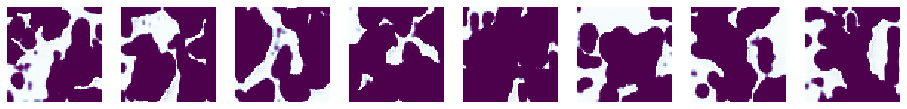

FID (same): -0.000
FID (different): 16.476


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:

for epoch in range(n_epochs):
    # train
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
    ):
        model.train(train_x)
    # test on holdout
    loss = []
    for batch, test_x in tqdm(
        zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES
    ):
        loss.append(model.compute_loss(train_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    # plot results
    display.clear_output()
    print(
        "Epoch: {} | disc_loss: {} | gen_loss: {}".format(
            epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]
        )
    )
    plot_reconstruction(model,train_images)

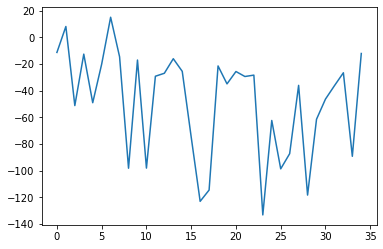

In [13]:
plt.plot(losses.gen_loss.values)

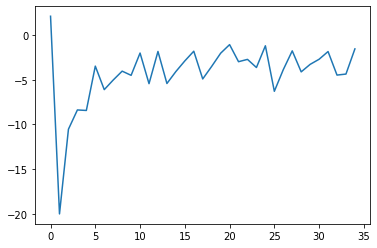

In [14]:
plt.plot(losses.disc_loss.values)